## Part 1: Feature Engineering

This notebook showcases different techniques for feature engineering and how they perform with the baseline model.

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging


logging.getLogger('fgclassifier').setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Format and Word Segmentation

First, check how word segmentation works with the library we chose:

In [19]:
import jieba
from config import valid_data_path, train_data_path
from fgclassifier import read_csv

df = read_csv(train_data_path, seg_words=False)

print(df['content'][0])
segs = jieba.lcut(df['content'][0])
print(" ".join(segs))

2018-11-13 17:20:46,954 [INFO] Reading data/train/sentiment_analysis_trainingset.csv..


"吼吼吼，萌死人的棒棒糖，中了大众点评的霸王餐，太可爱了。一直就好奇这个棒棒糖是怎么个东西，大众点评给了我这个土老冒一个见识的机会。看介绍棒棒糖是用德国糖做的，不会很甜，中间的照片是糯米的，能食用，真是太高端大气上档次了，还可以买蝴蝶结扎口，送人可以买礼盒。我是先打的卖家电话，加了微信，给卖家传的照片。等了几天，卖家就告诉我可以取货了，去大官屯那取的。虽然连卖家的面都没见到，但是还是谢谢卖家送我这么可爱的东西，太喜欢了，这哪舍得吃啊。"
" 吼吼 吼 ， 萌死 人 的 棒棒糖 ， 中 了 大众 点评 的 霸王餐 ， 太 可爱 了 。 一直 就 好奇 这个 棒棒糖 是 怎么 个 东西 ， 大众 点评 给 了 我 这个 土老冒 一个 见识 的 机会 。 看 介绍 棒棒糖 是 用 德国 糖 做 的 ， 不会 很甜 ， 中间 的 照片 是 糯米 的 ， 能 食用 ， 真是太 高端 大气 上档次 了 ， 还 可以 买 蝴蝶结 扎口 ， 送人 可以 买 礼盒 。 我 是 先 打 的 卖家 电话 ， 加 了 微信 ， 给 卖家 传 的 照片 。 等 了 几天 ， 卖家 就 告诉 我 可以 取货 了 ， 去 大官 屯 那取 的 。 虽然 连 卖家 的 面 都 没 见到 ， 但是 还是 谢谢 卖家 送 我 这么 可爱 的 东西 ， 太 喜欢 了 ， 这 哪 舍得吃 啊 。 "


In [3]:
# Replace blank space with some materialized words
jieba.add_word('BBLANKK')
jieba.lcut("我，来到北京  清华大学".replace(' ', 'BBLANKK'))

['我', '，', '来到', '北京', 'BBLANKK', 'BBLANKK', '清华大学']

In [4]:
df.iloc[0,:]

id                                                                                          0
content                                     "哎，想当年来佘山的时候，啥都没有，三品香算镇上最大看起来最像样的饭店了。菜品多，有点太多，...
location_traffic_convenience                                                               -2
location_distance_from_business_district                                                   -2
location_easy_to_find                                                                      -2
service_wait_time                                                                           0
service_waiters_attitude                                                                   -2
service_parking_convenience                                                                -2
service_serving_speed                                                                      -2
price_level                                                                                 1
price_cost_effective                                        

## 2. Basic Statistics

First, check how many records we have. As word segmentation takes a while, we read the raw data first.

In [5]:
from config import valid_data_path, train_data_path, testa_data_path

# Without segmentation, this is faster
df_train = read_csv(train_data_path, seg_words=False, sample_n=None)
df_valid = read_csv(valid_data_path, seg_words=False, sample_n=None)
print("Training data:", df_train.shape)
print("Validation data:", df_valid.shape)

2018-11-13 17:16:49,056 [INFO] Reading data/train/sentiment_analysis_trainingset.csv..
2018-11-13 17:16:53,414 [INFO] Reading data/valid/sentiment_analysis_validationset.csv..


Training data: (105000, 22)
Validation data: (15000, 22)


In [6]:
df_testa = read_csv(testa_data_path, seg_words=False, sample_n=None)
print("Test-A data:", df_testa.shape)

2018-11-13 17:16:54,352 [INFO] Reading data/test-a/sentiment_analysis_testa.csv..


Test-A data: (15000, 22)


Then let's check after segmentation, what does the data look like.

In [7]:
df_train_full = read_csv(train_data_path, seg_words=True, sample_n=None)
df_valid_full = read_csv(valid_data_path, seg_words=True, sample_n=None)

2018-11-13 17:16:55,083 [INFO] Read cache data/train/sentiment_analysis_trainingset.csv.segged_sample_None.tsv..
2018-11-13 17:17:02,348 [INFO] Read cache data/valid/sentiment_analysis_validationset.csv.segged_sample_None.tsv..


In [23]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

tokenizer = CountVectorizer().build_tokenizer()

def count_words(content, counter=None):
    counts = counter or Counter()
    sentences = []
    for s in content:
        ss = tokenizer(s)
        sentences.append(ss)
        counts.update(ss)
    return counts, sentences

count_train, sentences = count_words(df_train_full['content'])
print(count_train.most_common()[:10])

[('BBLANKK', 573592), ('味道', 124409), ('不错', 120832), ('感觉', 91453), ('可以', 90883), ('好吃', 83884), ('还是', 83418), ('没有', 75014), ('比较', 73069), ('我们', 67480)]


Looks like the tokenizer removed single-character Chinese words, which is not bad per se.

In [21]:
df_train_full['content'][0]

'吼吼 吼 ， 萌死 人 的 棒棒糖 ， 中 了 大众 点评 的 霸王餐 ， 太 可爱 了 。 一直 就 好奇 这个 棒棒糖 是 怎么 个 东西 ， 大众 点评 给 了 我 这个 土老冒 一个 见识 的 机会 。 看 介绍 棒棒糖 是 用 德国 糖 做 的 ， 不会 很甜 ， 中间 的 照片 是 糯米 的 ， 能 食用 ， 真是太 高端 大气 上档次 了 ， 还 可以 买 蝴蝶结 扎口 ， 送人 可以 买 礼盒 。 我 是 先 打 的 卖家 电话 ， 加 了 微信 ， 给 卖家 传 的 照片 。 等 了 几天 ， 卖家 就 告诉 我 可以 取货 了 ， 去 大官 屯 那取 的 。 虽然 连 卖家 的 面 都 没 见到 ， 但是 还是 谢谢 卖家 送 我 这么 可爱 的 东西 ， 太 喜欢 了 ， 这 哪 舍得吃 啊 。'

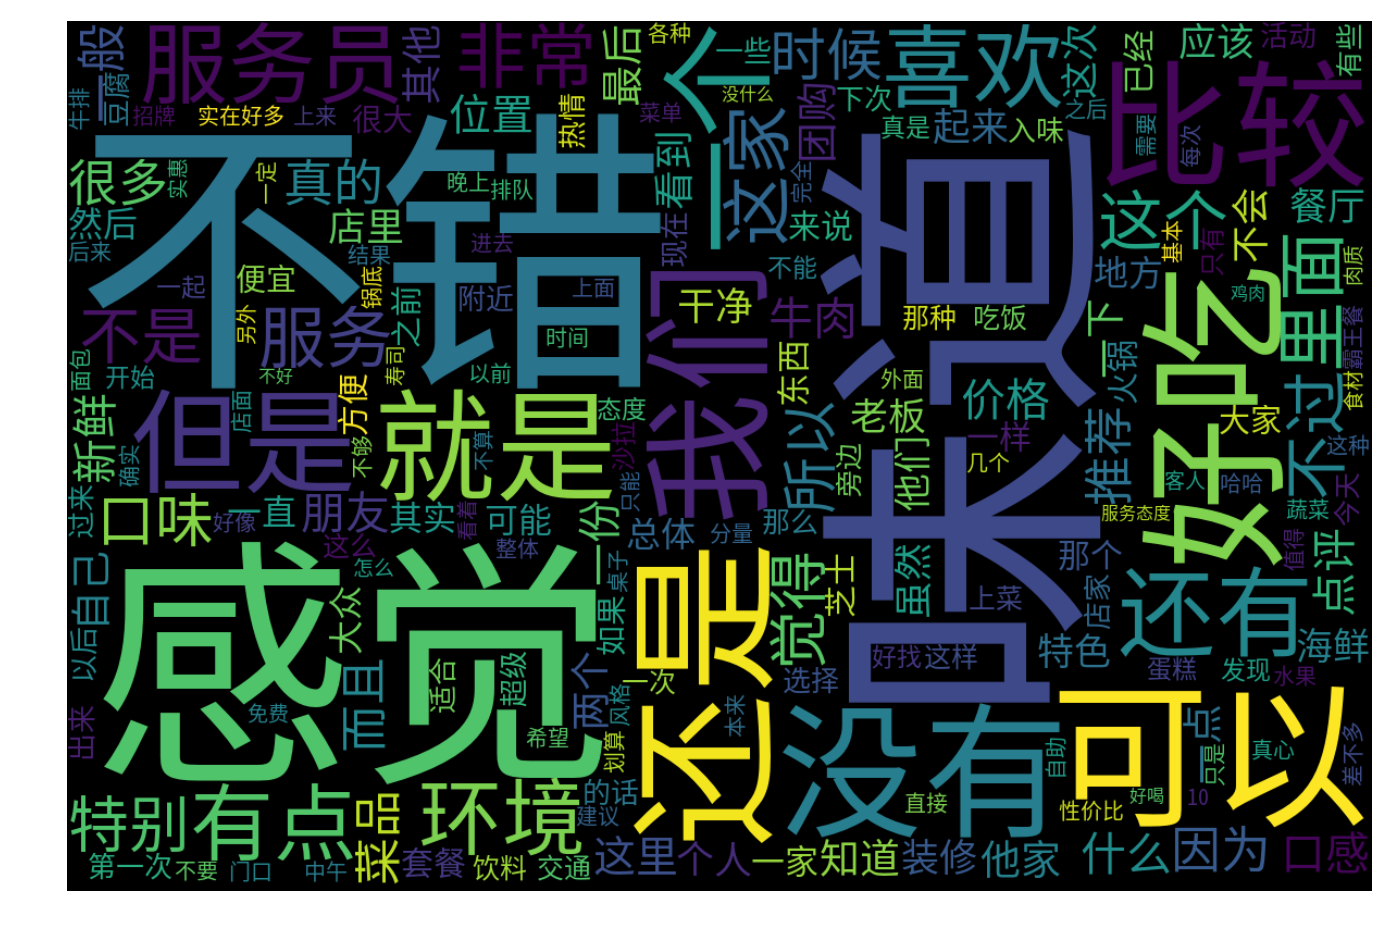

In [13]:
from wordcloud import WordCloud

font = './misc/SourceHanSansHWSC/SourceHanSansHWSC-Regular.otf'
wordcloud = WordCloud(
    font_path=font, width=1200, height=800,
    # background_color='rgb(55, 71, 79)',
).generate_from_frequencies(dict(count_train.most_common()[1:5000]))

plt.figure(figsize=(12, 8))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
print('Average review length: {}'.format(np.mean([len(s) for s in sentences])))
print('Vocabulary size: {}'.format(len(count_train)))

Average review length: 110.63200952380953
Vocabulary size: 218179


In [18]:
for s in sentences[:3]:
    print(s)

['吼吼', '萌死', '棒棒糖', '大众', '点评', '霸王餐', '可爱', '一直', '好奇', '这个', '棒棒糖', '怎么', '东西', '大众', '点评', '这个', '土老冒', '一个', '见识', '机会', '介绍', '棒棒糖', '德国', '不会', '很甜', '中间', '照片', '糯米', '食用', '真是太', '高端', '大气', '上档次', '可以', '蝴蝶结', '扎口', '送人', '可以', '礼盒', '卖家', '电话', '微信', '卖家', '照片', '几天', '卖家', '告诉', '可以', '取货', '大官', '那取', '虽然', '卖家', '见到', '但是', '还是', '谢谢', '卖家', '这么', '可爱', '东西', '喜欢', '舍得吃']
['第三次', '参加', '大众', '点评', '霸王餐', '活动', '这家', '整体', '感觉', '一般', '首先', '环境', '只能', '中等', '其次', '霸王餐', '提供', '菜品', '不是', '很多', '当然', '商家', '为了', '避免', '参加', '霸王餐', '吃不饱', '现象', '每桌', '提供', '至少', '六份', '主食', '我们', '那桌', '提供', '两份', '年糕', '第一次', '吃火锅', '桌上', '这么', '主食', '整体', '来说', '这家', '火锅店', '没有', '什么', '特别', '特色', '不过', '每份', '菜品', '分量', '还是', '比较', '这点', '肯定', '至于', '价格', '因为', '没有', '菜单', '了解', '不过', '大众', '这家', '团购', '代金券', '相当于', '应该', '价位', '不会', '最后', '还是', '感谢', '商家', '提供', '霸王餐', '生意兴隆', '财源', '广进']
['同行', 'BBLANKK', '10', '小吃', '榴莲', 'BBLANKK', '榴莲', '味道', '不足', 'BBLANKK', '松软', 'BBLANKK', '奶味', '

In [24]:
df_en = pd.read_csv('data/english.csv')
count_en, reviews_en = count_words(df_en['content'])

Most common: [('the', 158386), ('is', 114688), ('and', 65282), ('to', 54480), ('of', 47492), ('The', 41031), ('it', 36260), ('very', 34925), ('not', 28394), ('are', 27412)]
Average review length: 221.813 words
Vocabulary size: 28043


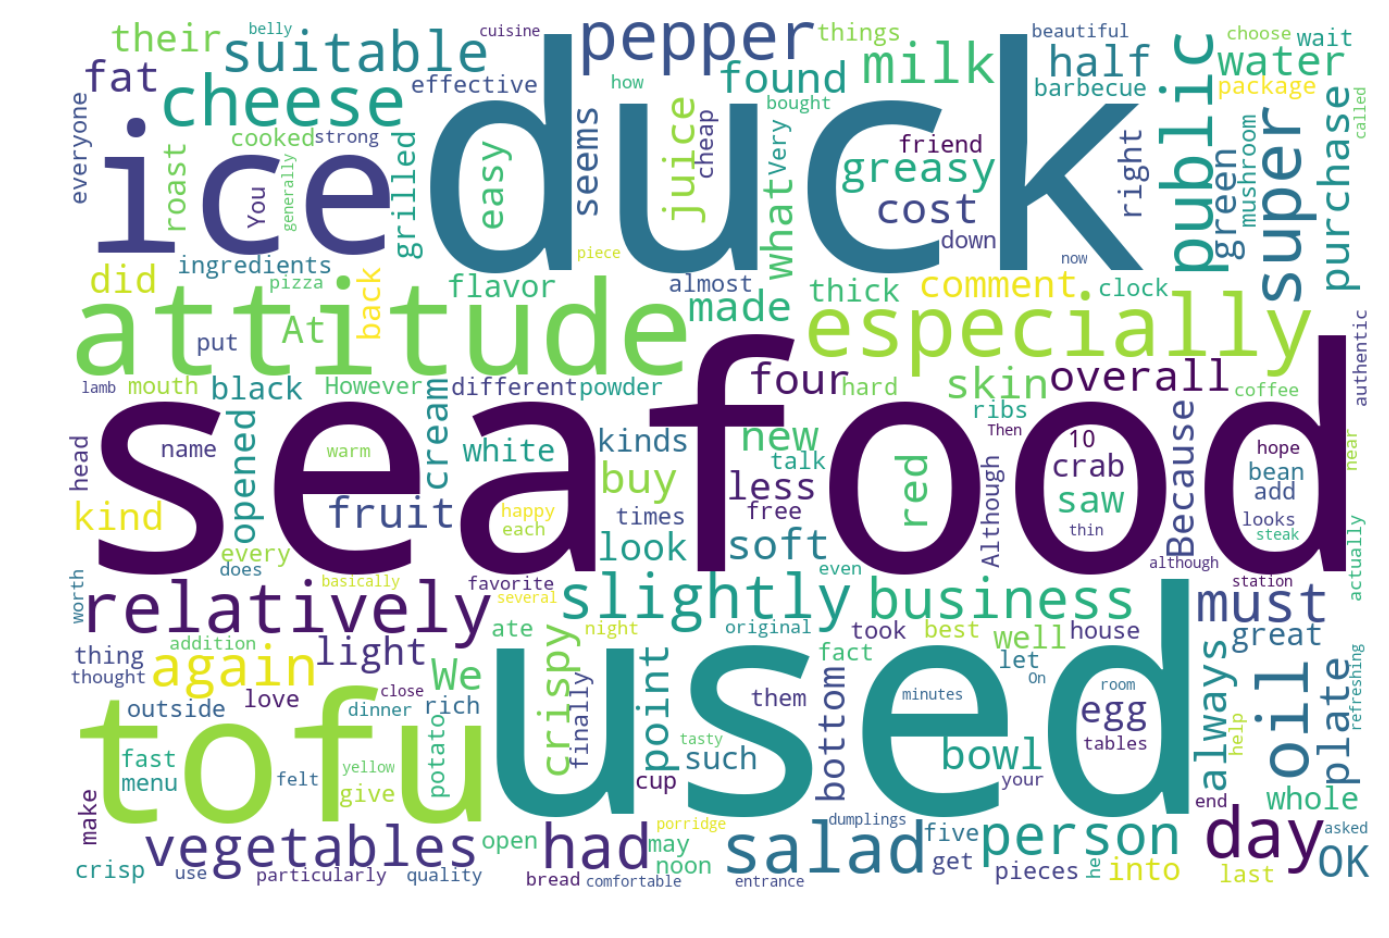

In [33]:
print('Most common: {}'.format(count_en.most_common()[:10]))
print('Average review length: {} words'.format(np.mean([len(s) for s in reviews_en])))
print('Vocabulary size: {}'.format(len(count_en)))


wordcloud = WordCloud(width=1200, height=800,
    background_color='#ffffff',
).generate_from_frequencies(dict(count_en.most_common()[190:10000]))

plt.figure(figsize=(12, 8))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Vocabulary size: 226006


In [20]:
import pandas as pd

df = pd.DataFrame({ 'values': list(count_train.values()) })
df.describe()

,values
count,2.260060e+05
mean,1.057855e+02
std,6.441985e+03
min,1.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,5.000000e+00
max,2.313637e+06


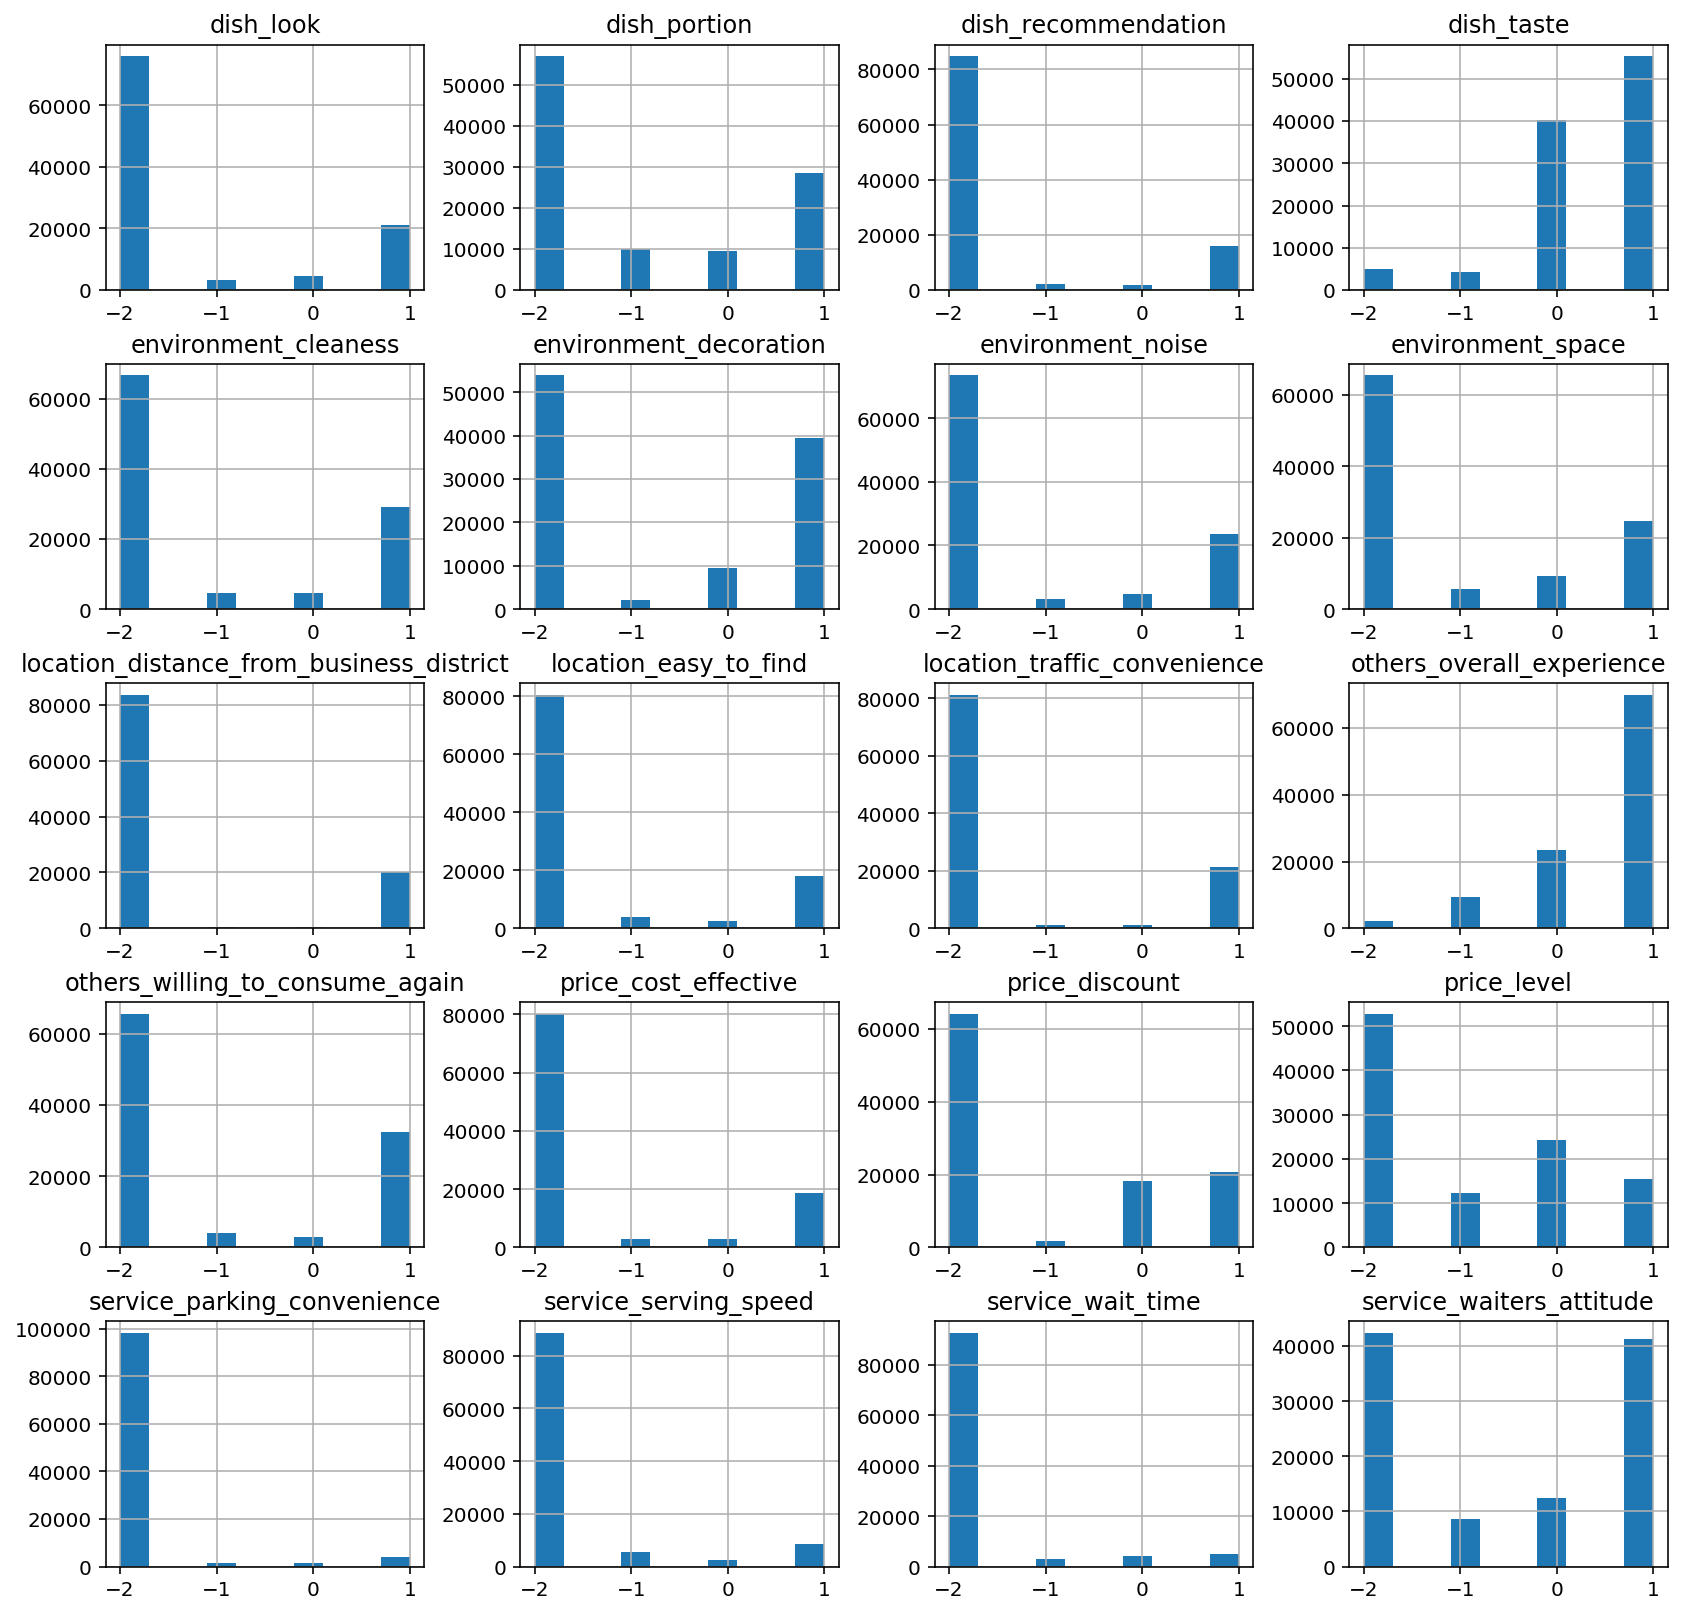

In [21]:
df_train.drop(['id', 'content'], axis=1).hist(figsize=(14, 14))
plt.show()

## Overall Distribution

In [ ]:
x = df_train.drop(['id', 'content'], axis=1).values.ravel()
plt.hist(x)
plt.xticks([-2, -1, 0, 1])
plt.show()

In [ ]:
import config
from fgclassifier.baseline import Indie

model = Indie()
X_train, Y_train = model.load(config.train_data_path, sample_n=1000)

## 3. Make English Translation

To help non-English speakers understand the content, we make a subset of the training data with English translations.

If you want to run the following code yourself, follow the instructions [here](https://cloud.google.com/translate/docs/quickstart-client-libraries#client-libraries-install-python).

In [1]:
from config import valid_data_path, train_data_path, testa_data_path
from fgclassifier import read_csv
from sklearn.externals import joblib

df_train = read_csv(train_data_path, seg_words=False, sample_n=None)

Building prefix dict from the default dictionary ...
2018-11-11 20:04:35,454 [DEBUG] Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/6r/772b4sy16rg94jhq1fskv9fc0000gn/T/jieba.cache
2018-11-11 20:04:35,457 [DEBUG] Loading model from cache /var/folders/6r/772b4sy16rg94jhq1fskv9fc0000gn/T/jieba.cache
Loading model cost 0.828 seconds.
2018-11-11 20:04:36,283 [DEBUG] Loading model cost 0.828 seconds.
Prefix dict has been built succesfully.
2018-11-11 20:04:36,285 [DEBUG] Prefix dict has been built succesfully.
2018-11-11 20:04:36,287 [INFO] Reading data/train/sentiment_analysis_trainingset.csv..


In [2]:
try:
    translations = joblib.load('data/train/en.pkl')
except:
    translations = {}

In [3]:
import glob
import time
from IPython.display import clear_output

from tqdm import tqdm
from google.cloud import translate
from sklearn.externals.joblib import Parallel, delayed

# All available credentials
credentials = glob.glob('./misc/google-cloud/*.json')

# Use multiple credentials to bypass rate limit
clients = []
for credential in credentials:
    print(credential)
    clients.append(translate.Client.from_service_account_json(credential))

df = df_train.copy().iloc[0:10000,:]
contents = [x.strip('"') for x in df['content']]
n_client = len(clients)
n_records = df.shape[0]

client_ok = [True for _ in clients]


def get_client(i):
    c = 0
    while not client_ok[i % n_client] and c < n_client:
        c += 1
        i += 1
    i = i % n_client
    client = clients[i] if c < n_client else None
    return i, client

failed = []

clear_output()
pbar = tqdm(total=n_records)
queue = list(range(n_records))
n_failed = 0

while len(queue) and n_failed < n_client:
    i = queue.pop(0)
    if i not in translations:
        start_time = time.time()
        client_idx, client = get_client(i)
        if not client:
            raise RuntimeError('No Available Client.')
        try:
            translation = client.translate(contents[i],
                target_language='en', source_language='zh')
            translations[i] = translation['translatedText']
        except Exception as e:
            # print(client_idx + 1, e)
            client_ok[client_idx] = False
            queue.append(i)
            n_failed += 1
            continue
        end_time = time.time()
        # If finished within 1 second, wait...
        if end_time < start_time + 0.5:
            time.sleep(start_time + 0.5 - end_time)
    pbar.update(1)

100%|██████████| 10000/10000 [05:05<00:00,  1.24s/it] 

In [4]:
joblib.dump(translations, 'data/train/en.pkl')

['en_train.pkl']

In [20]:
# Replace content with translation, and replace apostrophe 
df['content'] = [x.replace('&#39;', "'") for x in pd.Series(translations).sort_index()]

In [53]:
# Sanity Check
import numpy as np

idx = np.random.randint(0, 10000)
print(df_train['content'][idx])
print(df['content'][idx])

"【试吃点评】
【环境评价】坐落于一方莲花之中，转角之间悄然而见，似是脱俗，似是悠然。居于莲花大厦小区内，如若细心，不难发现。庭院之内，摆放着几张小桌，些许椅子，墨绿的遮阳篷下，几盏小茶，一个午后！
缓步入内，几个书架隔出了几个雅座，一席帘布，营造了小小的空间，或缱绻或仰卧，几多自由，一本闲书，一个时光！
【餐品评价】
【菊花茶】一盏花茶，淡淡的，虽没有多大特色，也就几许菊花，一壶开水，可是午后也该是慵懒的，回味间，菊花香阵阵而来，齿间也是舒适的。
【玫瑰花】于心，玫瑰于女生还是美颜之物，虽不知其中道理，可也是众星捧月的花茶之一。午后来一盏也是闲适之物，也给自己放个假。
【】落入盘中，一朵薄荷叶立中间，简单而富有画面，落入口中也是口感细腻，不会甜腻，一层【】有点微微苦感，却将本身微调出一种细细的美感，而我也钟爱这款甜点！
【榴莲班戟】一层薄薄的蛋皮，包裹住一腔美味，淡淡的奶油，不腻，口感细滑，据店家介绍，也是顶好的奶油调制而成，想来也是颇费苦心制作每一款产品。切成些许小块，更是很符合需求，不过大厨也说这个切的会些许麻烦，也可见其刀工。
【鸡蛋布丁】细滑的口感，精致的装盘，小小容器内足见一方明月，奶香十足，满口淡淡的香气，落入口中也是一佳品，据传这也是店内热销产品，也可见其口感之佳！
【综合评价】店内还有提供饭点，观其价格还是相对可以的，午后来次，一本闲书，一个午后，一盏花茶，一款甜点，足以！"
[Try to eat reviews] [Environmental evaluation] is located in a lotus flower, and the corners are quietly seen, it seems to be refined, it seems to be leisurely. Living in the Lotus Building, if you are careful, it is not difficult to find. Inside the courtyard, there are a few small tables, a few chairs, a dark green awning, a few small teas, one afternoon! Stepping into the room, several 

In [23]:
df.head(1).T

,0
id,0
content,"Hey, the lollipop of the dead man, the overlor..."
location_traffic_convenience,-2
location_distance_from_business_district,-2
location_easy_to_find,-2
service_wait_time,-2
service_waiters_attitude,1
service_parking_convenience,-2
service_serving_speed,-2
price_level,-2


In [26]:
# Save
import csv

# Sample data obtained by Google Translating to English
df.to_csv('data/english.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)